In [1]:
pwd

'/Users/tobiro/celesDataAna/celesDataAnalysis'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize

START

In [4]:
# Config Data
G = 1.9935608097491742e-38

ELLIPSE SETUP

In [85]:
# given phase input, return conic parameters
def retConicParam(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    TP = 2*math.pi*math.sqrt(math.pow(a,3)/mu)
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    print(ecc)
    print((a - np.linalg.norm(r))/(a*ecc), ecc)
    n = math.sqrt(mu/math.pow(a,3))
    E = math.acos((a - np.linalg.norm(r))/(a*ecc))
    theta = 2 * math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    axisThet = math.atan2(r[1],r[0])
    deltaThet = axisThet - theta
    M = E - ecc*math.sin(E)
    return {'a':a, 'ecc':ecc, 'TP':TP, 'n': n, 'E': E, 'M': M, 'mu': mu, 'theta': theta, 'axisThet': axisThet, 'deltaThet': deltaThet}

Newton Optimiser Step

In [86]:
def f(M, ecc):
    return lambda x: x - ecc * math.sin(x) - M

def fPrime(ecc):
    return lambda x: 1 - ecc * math.cos(x)

In [87]:
def conicPts(n, ecc, M,E, step):
    M1 = M + n*step
    E1 = optimize.newton(f(M1, ecc), E, fPrime(ecc))
    return E1

In [88]:
# return position of object given conic parameters and iterated vaue of E
def retPos(a, ecc, E, mu, deltaThet):
    r = a * (1 - ecc * math.cos(E))
    theta = 2*math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    return np.array([r*math.cos(theta+deltaThet), r*math.sin(theta+deltaThet)])

In [89]:
def retVel(a, ecc, E, mu, deltaThet):
    r = a * (1 - ecc * math.cos(E))
    theta = 2*math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    vr = math.sqrt(mu/(a * (1 - ecc*ecc))) * math.sin(theta) * ecc
    vTheta = math.sqrt(mu/(a * (1 - ecc*ecc))) * (1 + ecc * math.cos(theta))
    return np.array([vr, vTheta])

In [90]:
# returns all the points broken into N pieces
def getPts(parameters, r, N):
    step = parameters['TP']/N
    n = parameters['n']
    ecc = parameters['ecc']
    M = parameters['M']
    E = parameters['E']
    a = parameters['a']
    deltaThet = parameters['deltaThet']
    pnt = [np.copy(r)]
    print(pnt)
    mu = parameters['mu']
    for i in range(math.floor(N)):
        # M1 = M + n*step
        E1 = conicPts(n, ecc, M, E, step)
        r1 = retPos(a, ecc, E1, mu, deltaThet)
        E = E1
        M = E - ecc*math.sin(E)
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt
        

    

Execution

In [91]:
# op = {'M': 9e30 + 5.97E24, 'r': np.array([98.97611425091667,13.870014616378286]), 'v': np.array([-0.000019503017485248454, 0.000049878169854632976])}
op = {'M':  5.97E24, 'r': np.array([0.06684587122268226, 0]), 'v': np.array([0.000003342293561134223,  0.0000014739514604601942])}
parameters = retConicParam(op)
parameters

ValueError: math domain error

TESTING

In [26]:
op = {'M':  5.97E24, 'r': np.array([0.06684587122268226,0.0]), 'v': np.array([0, 8.054927482333463e-7])}
parameters = retConicParam(op)
parameters

0.6355868510455159
-1.0000000000000002 0.6355868510455159


ValueError: math domain error

In [397]:
pos = retPos(parameters['a'], parameters['ecc'], parameters['E'], parameters['mu'], parameters['deltaThet'])
pos

array([98.18567615, 18.21694812])

In [398]:
op['v']

array([-8.22008382e-06,  4.27728554e-05])

In [399]:
vel = retVel(parameters['a'], parameters['ecc'], parameters['E'], parameters['mu'], parameters['deltaThet'])
vel
np.linalg.norm(vel)
vel

array([2.79423496e-07, 4.35546652e-05])

In [400]:
v1 = np.cross([0,0,1], np.append(pos, 0))
v1 = v1/np.linalg.norm(v1)
v1 = v1*vel[1]
v2 = np.append(pos, 0)
v2 = v2/np.linalg.norm(v2)
v2 = v2*vel[0] * (-1)
v = v1 + v2
v
theta = 0.4730131763947535
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
v_rotated = np.dot(rotation_matrix, v)
v1,v2,v

(array([-7.94534898e-06,  4.28238285e-05,  0.00000000e+00]),
 array([-2.74734838e-07, -5.09731204e-08, -0.00000000e+00]),
 array([-8.22008382e-06,  4.27728554e-05,  0.00000000e+00]))

In [391]:
x = 98.42779164608572 + (-0.24211549108649283)
y = 17.662667739464933 + 0.5542803854455367
vx = -0.00000748156231829769 + (-7.385215013904116e-7)
vy =  0.00004169209702151818 + 0.000001080758344982951
x,y,vx,vy

(98.18567615499923,
 18.21694812491047,
 -8.220083819688101e-06,
 4.277285536650113e-05)

In [394]:
x = 98.60649124593908 + -0.22390735230816108
y = 16.63610183199588 + 0.5276001079057034
vx = -0.000007046728978065124 + -7.418613799929672e-7
vy = 0.000041767790694313174 + 0.000001088514944300731
x,y,vx,vy

(98.38258389363092,
 17.163701939901582,
 -7.78859035805809e-06,
 4.28563056386139e-05)

In [395]:
op = {'M': 9e30 + 5.97E24, 'r': np.array([x,y]), 'v': np.array([vx, vy])}
parameters = retConicParam(op)
parameters

105.80227961781175 99.86854098197844


{'a': 105.80227961781175,
 'ecc': 0.05652385925593865,
 'TP': 16143074.963894663,
 'n': 3.8921861672775816e-07,
 'E': 0.12493804899708612,
 'M': 0.11789442631623331,
 'mu': 1.7942059189300603e-07,
 'theta': 0.13219081801868193,
 'axisThet': 0.17272044487467078,
 'deltaThet': 0.04052962685598885}

In [298]:
theta = -0.8316024077529348

rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
rotated = np.dot(rotation_matrix, np.append(op['r'],0)/np.linalg.norm(op['r']))
rotated*parameters['a']

array([ 81.36822866, -61.62001964,   0.        ])

In [300]:
x = 98.18810449599195
y = 18.200396125997703
vx = -0.000008218772870769958
vy = 0.00004274821332120539
op = {'M': 9e30 + 5.97E24, 'r': np.array([x,y]), 'v': np.array([vx, vy])}
parameters = retConicParam(op)
parameters

105.6372381524162 99.8606943880277


{'a': 105.6372381524162,
 'ecc': 0.055085710012333304,
 'TP': 16105317.212129349,
 'n': 3.9013111163358834e-07,
 'E': 0.12101667535863408,
 'M': 0.1143666453038734,
 'mu': 1.7942059189300603e-07,
 'theta': 0.12785895155742882,
 'axisThet': 0.1832822830037649,
 'deltaThet': 0.05542333144633607}

In [39]:
np.linalg.norm(op['v'])

5.355557411770996e-05

In [386]:
pos = retPos(parameters['a'], parameters['ecc'], parameters['E'], parameters['mu'], parameters['deltaThet'])
pos

array([98.18567615, 18.21694812])

In [387]:
vel = retVel(parameters['a'], parameters['ecc'], parameters['E'], parameters['mu'], parameters['deltaThet'])
vel
np.linalg.norm(vel)
vel
# vel = np.array([-1.2392255e-05,5.2102126e-05])

array([9.70346721e-07, 4.28319783e-05])

In [56]:
np.cross([0,0,1], np.append(pos, 0))

array([-13.87001462,  98.97611425,   0.        ])

In [390]:
v1 = np.cross([0,0,1], np.append(pos, 0))
v1 = v1/np.linalg.norm(v1)
v1 = v1*vel[1]
v2 = np.append(pos, 0)
v2 = v2/np.linalg.norm(v2)
v2 = v2*vel[0] * (-1)
v = v1 + v2
v
theta = 0.4730131763947535
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
v_rotated = np.dot(rotation_matrix, v)
v1,v2,v

(array([-7.81351467e-06,  4.21132681e-05,  0.00000000e+00]),
 array([-9.54064540e-07, -1.77013032e-07, -0.00000000e+00]),
 array([-8.76757921e-06,  4.19362551e-05,  0.00000000e+00]))

In [389]:
op['v']

array([-8.76757921e-06,  4.19362551e-05])

TESTING END

In [11]:
fpnts = getPts(parameters, op['r'], 5000)

[array([98.97611425, 13.87001462])]


(-400.3141001244116, 123.52629079182583, -156.1042617849937, 297.753658927755)

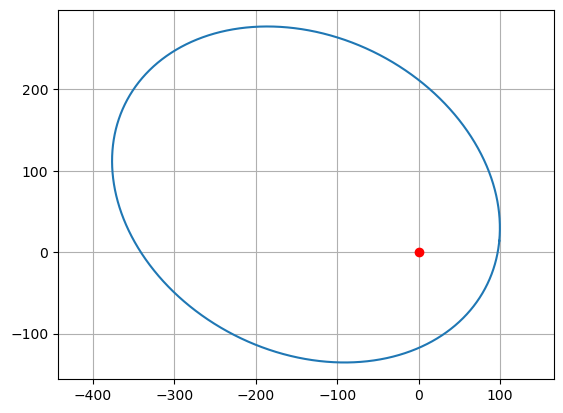

In [12]:
df = pd.DataFrame(columns=['x', 'y'])
df['x'] = fpnts[:, 0]
df['y'] = fpnts[:, 1]
plt.plot(df['x'], df['y']) 
plt.plot(0,0, 'ro')
plt.grid()
plt.axis('equal')

HYPOERBOLIC SETUP

In [202]:
# given phase input, return conic parameters [input, mass, position, velocity]
def retConicParamH(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    rlen = np.linalg.norm(r)
    istowardsperi = np.dot(v,r) < 0
    isclockwise = np.cross(np.append(r,0),np.append(v,0))[2] > 0
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    n = math.sqrt(mu/math.pow(-a,3))
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    print(ecc)
    print((1 - np.linalg.norm(r)/a)/ecc)
    if abs((1 - np.linalg.norm(r)/a)/ecc) < 1:
        F = math.acosh(1)
    else:
        F = math.acosh((1 - np.linalg.norm(r)/a)/ecc)
    # F = math.acosh((1 - np.linalg.norm(r)/a)/ecc) 
    thet = 2*math.atan(math.sqrt((1+ecc)/(ecc-1)) * math.tanh(F/2))
    axisThet = math.acos(np.dot(r, [1,0])/np.linalg.norm(r))
    deltaThet = axisThet - thet
    totThet = axisThet+thet
    M = ecc*math.sinh(F) - F 
    return {'a':a, 'ecc':ecc, 'n':n, 'F': F, 'M': M, 'mu': mu, 'h':h, 'thet':thet, 'axisThet':axisThet, 'deltaThet':deltaThet,'totThet':totThet ,'istowardsperi':istowardsperi, 'isclockwise':isclockwise}

In [6]:
def fH(M, ecc):
    return lambda x: ecc * math.sinh(x) - x - M

def fHPrime(ecc):
    return lambda x: ecc * math.cosh(x) - 1

In [7]:
def conicPtsH(n, ecc, M,F, step):
    M1 = M + n*step
    F1 = optimize.newton(fH(M1, ecc), F, fHPrime(ecc))
    return F1

In [203]:
# return position of object given conic parameters and iterated vaue of E
def retPosH(a, ecc, F, mu, delThet, isclockwise, totTheta):
    r = 1 * -a * ( ecc * math.cosh(F) - 1)
    theta = 2*math.atan(math.sqrt((1+ecc)/(ecc - 1)) * math.tanh(F/2))
    if isclockwise != True:
        theta = -theta
    # rotation_matrix = np.array([[np.cos(delThet), -np.sin(delThet)],
    #                         [np.sin(delThet), np.cos(delThet)]])
    # return np.dot(rotation_matrix, np.array([r*math.cos(theta), r*math.sin(theta)]))
    # return np.array([r*math.cos(theta+delThet), r*math.sin(theta+delThet)])
    return np.array([r*math.cos(totTheta-theta), r*math.sin(totTheta-theta)])

def retVelH(a, ecc, F, mu, delThet):
    r = 1 * -a * ( ecc * math.cosh(F) - 1)
    theta = 2*math.atan(math.sqrt((1+ecc)/(ecc - 1)) * math.tanh(F/2))
    # vr = math.sqrt(mu/(-a * (ecc*ecc - 1))) * math.sinh(theta) * ecc *(1)
    # vTheta = math.sqrt(mu/(-a * (ecc*ecc - 1))) * (1 + ecc * math.cosh(theta)) * (1)
    
    # vr = (math.sqrt(mu*(-a))/r) * math.sinh(F) * (1)
    # vTheta = (math.sqrt(mu*(-a))/r) * math.sqrt(ecc*ecc - 1) * math.cosh(F) *(1)

    vel = math.sqrt(mu*(2/r - 1/a))
    fltAng = math.atan(ecc*math.sin(theta)/(1 + ecc*math.cos(theta)))
    vr = vel * math.sin(fltAng)
    vTheta = vel * math.cos(fltAng)

    return np.array([vr, vTheta])

In [136]:
def retVelHCatesianConvert(pos, vel):
    v1 = np.cross([0,0,1], np.append(pos*(1), 0))
    v1 = v1/np.linalg.norm(v1)
    v1 = v1*vel[1] * (1)
    v2 = np.append(pos*(1), 0)
    v2 = v2/np.linalg.norm(v2)
    v2 = v2*vel[0]*(1)
    v = v1 + v2
    return v



In [204]:
# returns all the points broken into N pieces
def getPtsH(parameters, r, N):
    n = parameters['n']
    # step = math.pi*2/(n*N) 
    step = 30
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    delThet = parameters['deltaThet']
    isclockwise = parameters['isclockwise']
    totTheta = parameters['totThet']
    pnt = [np.copy(r)]
    # print(pnt)
    mu = parameters['mu']
    # print(step)
    for i in range(math.floor(N/10)):
        F1 = conicPtsH(n, ecc, M, F, step)
        r1 = retPosH(a, ecc, F1, mu, delThet, isclockwise, totTheta)
        F = F1
        M = ecc*math.sinh(F) - F
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt

#reverse points
def getPtsHRev(parameters, r, N, pnt):
    n = parameters['n']
    step = 100
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    delThet = parameters['deltaThet']
    isclockwise = parameters['isclockwise']
    totTheta = parameters['totThet']
    pnt = pnt
    # print(pnt)
    mu = parameters['mu']
    # print(step)
    for i in range(math.floor(N/10)):
        F1 = conicPtsH(n, ecc, M, F, (-1)*step)
        r1 = retPosH(a, ecc, F1, mu, delThet,isclockwise, totTheta)
        F = F1
        M = ecc*math.sinh(F) - F
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt

In [205]:
def getposVelH(parameters, r, vel):
    n = parameters['n']
    # step = math.pi*2/(n*N) 
    step = 300
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    delThet = parameters['deltaThet']
    pnt = [np.copy(r)]
    vel = [np.copy(vel)]
    # print(pnt)
    mu = parameters['mu']
    # print(step)
    for i in range(math.floor(10)):
        F1 = conicPtsH(n, ecc, M, F, step)
        r1 = retPosH(a, ecc, F1, mu, delThet)
        F = F1
        M = ecc*math.sinh(F) - F
        vel1 = retVelH(parameters['a'], parameters['ecc'], F1, parameters['mu'], parameters['deltaThet'])
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
        vel = np.append(vel, [np.copy(vel1)], axis=0)
    return pnt,vel

In [206]:
# opH = {'M':  5.97E24, 'r': np.array([0.06684587122268226,0.0]), 'v': np.array([0,  0.0000021424101726870353])}
opH = {'M':  5.97E24, 'r': np.array([0.06684587122268226, 0]), 'v': np.array([-0.000003342293561134223,  0.0000014739514604601942])}
# opH = {'M': 9e30,  'r': np.array([11.89203237965344,59.17526544546777]), 'v': np.array([-0.00006254039044674874, 0.000047661858645905403])}
parametersH = retConicParamH(opH)


parametersH

2.7756819550325194
2.339763823068326


{'a': -0.012166093089185566,
 'ecc': 2.7756819550325194,
 'n': 0.00025708409356627586,
 'F': 1.4940414218836702,
 'M': 4.377359049137077,
 'mu': 1.190155803420257e-13,
 'h': 9.852756951440658e-08,
 'thet': 1.4913748150891686,
 'axisThet': 0.0,
 'deltaThet': -1.4913748150891686,
 'totThet': 1.4913748150891686,
 'istowardsperi': True,
 'isclockwise': True}

In [107]:
math.acos(np.dot(opH['r'], opH['v'])/(np.linalg.norm(opH['r'])*np.linalg.norm(opH['v'])))

0.41534436727029267

In [47]:
parametersH['a']*(1 - math.pow(parametersH['ecc'],2))

101.508795289899

In [48]:
np.linalg.norm(opH['r'])

60.35836706422978

In [45]:
0.06/0.08

0.75

In [85]:
getposVelH(parametersH, opH['r'], opH['v'])

(array([[0.06684587, 0.        ],
        [0.06784737, 0.00044218],
        [0.06884655, 0.00088435],
        [0.06984346, 0.00132649],
        [0.07083818, 0.00176859],
        [0.07183077, 0.00221063],
        [0.07282128, 0.00265261],
        [0.07380978, 0.00309452],
        [0.07479632, 0.00353634],
        [0.07578095, 0.00397808],
        [0.07676372, 0.00441972]]),
 array([[-3.34229356e-06,  1.47395146e-06],
        [ 1.20473320e-06,  3.44084871e-06],
        [ 1.20526580e-06,  3.43322428e-06],
        [ 1.20573690e-06,  3.42581584e-06],
        [ 1.20615103e-06,  3.41861471e-06],
        [ 1.20651236e-06,  3.41161260e-06],
        [ 1.20682475e-06,  3.40480168e-06],
        [ 1.20709175e-06,  3.39817446e-06],
        [ 1.20731663e-06,  3.39172386e-06],
        [ 1.20750245e-06,  3.38544310e-06],
        [ 1.20765200e-06,  3.37932576e-06]]))

In [132]:
opH

{'M': 9e+30,
 'r': array([11.89203238, 59.17526545]),
 'v': array([-6.25403904e-05,  4.76618586e-05])}

In [137]:
F1 = conicPtsH(parametersH['n'], parametersH['ecc'], parametersH['M'], parametersH['F'], 300)
r1 = retPosH(parametersH['a'], parametersH['ecc'], F1, parametersH['mu'], parametersH['deltaThet'])
vel = retVelH(parametersH['a'], parametersH['ecc'], F1, parametersH['mu'], parametersH['deltaThet'])
print(r1)
vel = retVelHCatesianConvert(r1, vel)
print(vel)

F = F1
M = parametersH['ecc']*math.sinh(F) - F

[11.87326983 59.18956183]
[-6.25432984e-05  4.76473755e-05  0.00000000e+00]


In [56]:
out = getPtsH(parametersH, opH['r'], 50)
out

array([[0.06684587, 0.        ],
       [0.06684467, 0.00064272],
       [0.06684108, 0.00128542],
       [0.06683509, 0.00192807],
       [0.0668267 , 0.00257065],
       [0.06681592, 0.00321314]])

In [ ]:
out = retVelH()

TESTINg

In [123]:
opH['v']

array([-3.34229356e-06,  1.47395146e-06])

In [154]:
posH = retPosH(parametersH['a'], parametersH['ecc'], parametersH['F'], parametersH['mu'], parametersH['deltaThet'])
posH

array([0.06684587, 0.        ])

In [129]:

vel = retVelH(parametersH['a'], parametersH['ecc'], parametersH['F'], parametersH['mu'], parametersH['deltaThet'])
vel
# np.linalg.norm(vel)
# vel  = np.array([-7.50356232e-06, 8.74471392e-05])
# vel
# vel = np.array([-3.23015155e-05, 7.16907616e-05])


array([3.34229356e-06, 1.47395146e-06])

In [98]:
opH

{'M': 5.97e+24,
 'r': array([0.06684587, 0.        ]),
 'v': array([-3.34229356e-06,  1.47395146e-06])}

In [110]:
np.linalg.norm(opH['v'])

3.652869989007551e-06

In [106]:
math.acos(np.dot(opH['r'], opH['v'])/(np.linalg.norm(opH['r'])*np.linalg.norm(opH['v'])))

0.41534436727029267

In [114]:
v1 = np.cross([0,0,1], np.append(posH*(1), 0))
print(v1)
v1 = v1/np.linalg.norm(v1)
print(v1)
v1 = v1*vel[1] * (1)
v2 = np.append(posH*(1), 0) 
v2 = v2/np.linalg.norm(v2)
print(v2)
v2 = v2*vel[0]*(-1)
v = v1 + v2
v
theta = parametersH['thet']*(-1)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
v_rotated = np.dot(rotation_matrix, v)
v1,v2, v, v_rotated, theta


[0.         0.06684587 0.        ]
[0. 1. 0.]
[1. 0. 0.]


(array([0.0000000e+00, 3.4486983e-06, 0.0000000e+00]),
 array([-1.2041342e-06, -0.0000000e+00, -0.0000000e+00]),
 array([-1.2041342e-06,  3.4486983e-06,  0.0000000e+00]),
 array([3.34229356e-06, 1.47395146e-06, 0.00000000e+00]),
 -1.4913748150891686)

In [43]:
opH['v']
# np.linalg.norm(opH['v'])

array([0.00000000e+00, 2.14241017e-06])

In [359]:
# opH = {'M': 9e30, 'r': np.array([140,0]), 'v': np.array([0, 0.000051])}
opH = {'M': 9e30,  'r': np.array([140,0]), 'v': np.array([-0.00003, 0.000051])}
parametersH = retConicParamH(opH)
parametersH

{'a': -191.3103361425597,
 'ecc': 1.5764528521572183,
 'n': 1.6007678242116555e-07,
 'F': 0.4403682702602054,
 'M': 0.2765077849770554,
 'mu': 1.7942047287742567e-07,
 'h': 0.00714,
 'thet': 0.859164872058229,
 'axisThet': 0.0,
 'deltaThet': -0.859164872058229}

In [155]:
posH = retPosH(parametersH['a'], parametersH['ecc'], parametersH['F'], parametersH['mu'], parametersH['deltaThet'])
posH

array([0.06684587, 0.        ])

In [361]:
np.linalg.norm(opH['v'])

5.9169248769948064e-05

In [19]:
vel = retVelH(parametersH['a'], parametersH['ecc'], parametersH['F'], parametersH['mu'], parametersH['deltaThet'])
vel
# np.linalg.norm(vel)

array([1.2041342e-06, 3.4486983e-06])

In [20]:

v1 = np.cross([0,0,1], np.append(posH*(1), 0))
print(v1)
v1 = v1/np.linalg.norm(v1)
print(v1)
v1 = v1*vel[1] * (1)
v2 = np.append(posH*(1), 0)
v2 = v2/np.linalg.norm(v2)
print(v2)
v2 = v2*vel[0]*(-1)
v = v1 + v2
v
theta = parametersH['deltaThet']
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
v_rotated = np.dot(rotation_matrix, v)
v1,v2, v, v_rotated

[0.         0.06684587 0.        ]
[0. 1. 0.]
[1. 0. 0.]


(array([0.0000000e+00, 3.4486983e-06, 0.0000000e+00]),
 array([-1.2041342e-06, -0.0000000e+00, -0.0000000e+00]),
 array([-1.2041342e-06,  3.4486983e-06,  0.0000000e+00]),
 array([3.34229356e-06, 1.47395146e-06, 0.00000000e+00]))

In [353]:
np.linalg.norm(opH['v'])

5.9169248769948064e-05

In [354]:
opH['v']

array([-3.0e-05,  5.1e-05])

In [58]:
np.array([])

array([], dtype=float64)

In [207]:
fpntsH = getPtsH(parametersH, opH['r'], 5000)
fpntsH

# fpntsH = getPtsHRev(parametersH, opH['r'], 5000, fpntsH[::-1])


# fpntsH = getPtsHRev(parametersH, opH['r'], 5000, np.array([opH['r']]))

array([[ 6.68458712e-02,  0.00000000e+00],
       [ 6.69461281e-02, -4.42185412e-05],
       [ 6.70463610e-02, -8.84370666e-05],
       ...,
       [ 1.14773200e-01, -2.18831881e-02],
       [ 1.14866678e-01, -2.19267647e-02],
       [ 1.14960148e-01, -2.19703398e-02]])

In [166]:
fpntsH.shape[0]

501

(-0.13186572798030918,
 0.12671376094272072,
 -0.024158622390780787,
 0.023983595113915717)

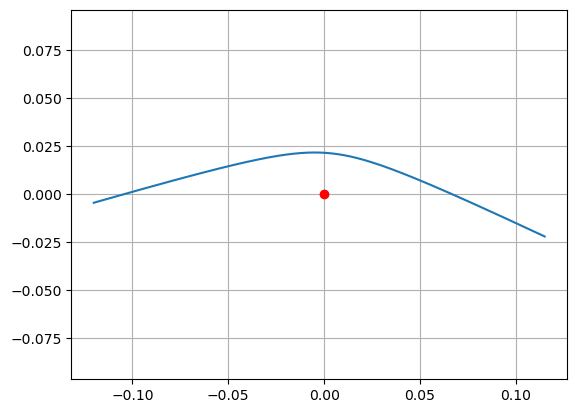

In [201]:
dfH = pd.DataFrame(columns=['x', 'y'])
dfH['x'] = fpntsH[:, 0]
dfH['y'] = fpntsH[:, 1]
plt.plot(dfH['x'], dfH['y'])
plt.plot(0,0, 'ro')
# plt.xlim(-500,500)
# plt.ylim(-500,500)
plt.grid('equal')
plt.axis('equal')
